In [1]:
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset
from math import sqrt
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [2]:
def extract_data(path,create_test=None):
    X_train=[]
    y_train=[]
    X_test=[]
    y_test=[]

    file=os.listdir(path)

    for entity in file:
        try:
            entityPath=os.listdir(f"{path}/{entity}")
            for i,data in enumerate(entityPath):
                try:
                    current_img=cv2.imread(f"{path}/{entity}/{data}")
                    if current_img is not None:
                        if (create_test is not None and ((len(entityPath)>1) and (i==0))):
                            X_test.append(current_img)
                            y_test.append(entity)
                        else:
                            X_train.append(current_img)
                            y_train.append(entity)
                    else:
                        print(f"{path}/{entity}/{data} is None type")
                except Exception as e:
                    print(f"Erreur avec {path}/{entity}/{data} : {e}")
        except Exception as ex:
            print(f"Erreur avec {path}/{entity} : {ex}")
    
    print(f"Number of training sample : {len(X_train)}\n")
    if create_test is not None:
        print(f"Number of test sample : {len(X_test)}\n")
        return X_train,y_train,X_test,y_test
    else:
        return X_train,y_train

In [ ]:
transform_face_test=transforms.Compose([
    transforms.ToPILImage(), #transforme en format PIL
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100,100)),
    transforms.ToTensor() #reconvertit l'img en format tensor
])

transform_face=transforms.Compose([
    transforms.ToPILImage(), #transforme en format PIL
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100,100)),
    #transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(), #0.5 de proba d'inverser la gauche et la droite de l'img pour rendre le modèle invariant à la symétrie
    transforms.RandomRotation(15), #applique rota random entre -10° et +10° 
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.2,hue=0.02), #altère aléatoirement la luminosité et le contraste de l'image
    transforms.ToTensor(), #reconvertit l'img en format tensor
    #transforms.RandomErasing(p=0.2),
])

transform_eyes=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,50)),
    transforms.ToTensor()
])

transform_eyes_test=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((50,50)),
    transforms.ToTensor()
])

In [4]:
def extract_face_and_eyes(img):
    if not isinstance(img,np.ndarray):
        img=cv2.imread(img)

    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(60,60)
    )

    if len(faces)==0:
        return [],[]
    
    x,y,w,h=faces[0]
    face=img[y:y+h,x:x+w]
    eyes=eye_cascade.detectMultiScale(cv2.cvtColor(face,cv2.COLOR_BGR2GRAY))
    if len(eyes)==2:
        if eyes[0][0]<eyes[1][0]:
            x2=eyes[0][0]
            w2=eyes[1][0]+eyes[1][2]-x2
        else:
            x2=eyes[1][0]
            w2=eyes[0][0]+eyes[0][2]-x2
        if eyes[0][1]<eyes[1][1]:
            y2=eyes[0][1]
            h2=eyes[1][1]+eyes[1][3]-y2
        else:
            y2=eyes[1][1]
            h2=eyes[0][1]+eyes[0][3]-y2
        imgEyes=face[y2:y2+h2,x2:x2+w2]
        return face,imgEyes
    else:
        return face,[]
    

In [5]:
def createData(X):
    X_face=[]
    X_eyes=[]
    for i,x in enumerate(X):
        face,eyes=extract_face_and_eyes(x)
        if len(face)!=0:
            X_face.append(face)
        else:
            X_face.append(np.zeros((100, 100, 3), dtype=np.uint8))
        if len(eyes)!=0:
            X_eyes.append(eyes)
        else:
            X_eyes.append(np.zeros((50, 50, 3), dtype=np.uint8))
    return X_face,X_eyes

In [6]:
class FaceEyesDataset(Dataset):
    def __init__(self, X, y, labels, transform_face, transform_eyes):
        self.X = X  # Liste des chemins ou images
        self.y = [labels[label] for label in y]  # Labels convertis en indices
        self.transform_face = transform_face
        self.transform_eyes = transform_eyes

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]

        if not isinstance(img, np.ndarray):
            img = cv2.imread(img)

        face, eyes = extract_face_and_eyes(img)

        if not isinstance(face, np.ndarray) or face.size == 0:
            face = np.zeros((100, 100, 3), dtype=np.uint8)
        if not isinstance(eyes, np.ndarray) or eyes.size == 0:
            eyes = np.zeros((50, 50, 3), dtype=np.uint8)

        face = self.transform_face(face)
        eyes = self.transform_eyes(eyes)

        label = self.y[idx]
        return face, eyes, label

def fusion_train(X_train,y_train,nb_epoch,labels,batch_size,models=None,patience=5,val_split=False):
    nb_classes=len(list(set(y_train)))
    facemodel,eyesmodel,fusionModel=feature_fusionModel(nb_classes)
    if models is not None:
        facemodel.load_state_dict(torch.load(models[0]))
        eyesmodel.load_state_dict(torch.load(models[1]))
        fusionModel.load_state_dict(torch.load(models[2]))
    
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fusionModel.to(device)
    facemodel.to(device)
    eyesmodel.to(device)

    if val_split:
        X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=1,stratify=y_train)
        val_dataset=FaceEyesDataset(X_val,y_val,labels,transform_face=transform_face_test,transform_eyes=transform_eyes_test)
        val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
        best_val_acc=0
        wait=0

    train_dataset=FaceEyesDataset(X_train,y_train,labels,transform_face=transform_face,transform_eyes=transform_eyes)
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

    criterion=torch.nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(list(facemodel.parameters())+list(eyesmodel.parameters())+list(fusionModel.parameters()), lr=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode="max")
    #on veut optimiser les poids des trois modèles en même temps
    tabTrain=[]
    tabVal=[]
    for epoch in range(nb_epoch):
        fusionModel.train()
        facemodel.train()
        eyesmodel.train()

        total_loss=0.0
        correct=0
        total=0

        for face_batch,eyes_batch,y_batch in train_loader:
            face_batch=face_batch.to(device)
            eyes_batch=eyes_batch.to(device)
            y_batch=y_batch.to(device)

            optimizer.zero_grad()

            featuresFaces=facemodel(face_batch)
            featuresEyes=eyesmodel(eyes_batch)
            featuresFusion=torch.cat((featuresFaces,featuresEyes),dim=1)
            outputs=fusionModel(featuresFusion)

            loss=criterion(outputs,y_batch)
            loss.backward()
            optimizer.step()

            total_loss+=loss.item()
            _,predicted=torch.max(outputs,1)
            correct+=(predicted==y_batch).sum().item()
            total+=y_batch.size(0)
        
        acc=100*correct/total
        tabTrain.append(acc)
        print(f"\nEpoch : {epoch+1}/{nb_epoch}\n Perte :{total_loss:.4f}\n Accuracy : {acc:.2f}%")

        if val_split:
            true,false,tot=fusionEvaluate((facemodel,eyesmodel,fusionModel),val_loader,labels)
            val_acc=sum(true.values())/sum(tot.values())
            scheduler.step(val_acc)
            tabVal.append(100*val_acc)
            if val_acc>best_val_acc:
                best_val_acc=val_acc #si l'acc de la val est meilleure on l'assigne et on reset le timer 
                wait=0
                best_model_faces=copy.deepcopy(facemodel.state_dict())
                best_model_eyes=copy.deepcopy(eyesmodel.state_dict())
                best_model_fusion=copy.deepcopy(fusionModel.state_dict())
            else:
                wait+=1
                if wait>=patience: #on attend le nombre d'epoch max sans amélioration
                    print("Early stopping activated")
                    break
            print(f"\n Val accuracy : {val_acc*100:.2f}%\n Série sans amélioration : {wait}")
    facemodel.load_state_dict(best_model_faces)
    eyesmodel.load_state_dict(best_model_eyes)
    fusionModel.load_state_dict(best_model_fusion)
        
    absc=list(range(len(tabTrain)))
    plt.figure(figsize=(8,5))
    plt.plot(absc,tabTrain,label="Training",marker="o")
    if val_split:
        plt.plot(absc,tabVal,label="Validation",marker="s")
    plt.xlim(1,len(tabTrain))
    plt.ylim(0,100)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    print("Training terminé.")
    plt.show()
    return facemodel,eyesmodel,fusionModel

In [7]:
def fusionEvaluate(models,loader,labels,graph=False):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    facemodel,eyesmodel,fusionmodel=models
    facemodel.to(device)
    facemodel.eval()
    eyesmodel.to(device)
    eyesmodel.eval()
    fusionmodel.to(device)
    fusionmodel.eval()

    labelF=defaultdict(int)
    labelC=defaultdict(int)
    labelT=defaultdict(int)

    with torch.no_grad():
        for faces_batch,eyes_batch,y_batch in loader:
            faces_batch=faces_batch.to(device)
            eyes_batch=eyes_batch.to(device)
            y_batch=y_batch.to(device)

            featuresFaces=facemodel(faces_batch)
            featuresEyes=eyesmodel(eyes_batch)
            featuresFusion=torch.cat((featuresFaces,featuresEyes),dim=1)
            outputs=fusionmodel(featuresFusion)

            _,pred=torch.max(outputs,1)
            for i in range(len(y_batch)):
                label=y_batch[i].item()
                pred[i]=pred[i].item()

                if pred[i]==label:
                    labelC[label]+=1
                else:
                    labelF[label]+=1
                labelT[label]+=1

    if graph:
        print(f"Total accuracy : {sum(labelC.values())/sum(labelT.values())*100:.2f}%")
        precisions={}
        for label in labelT:
            tot=labelT[label]
            correct=labelC.get(label,0)
            precisions[label]=correct/tot if tot>0 else 0
        prec_sorted=sorted(precisions.items(),key=lambda x: x[1])
        labels_ids,values= zip(*prec_sorted)

        id2label = {v: k for k, v in labels.items()}
        class_names=[id2label[i] for i in labels_ids]

        plt.figure(figsize=(12, 5))
        plt.bar(class_names, values, color='skyblue')
        plt.xticks(rotation=45)
        plt.ylabel("Accuracy par classe")
        plt.title("Performance du modèle par classe")
        plt.tight_layout()
        plt.show()
    
    return labelC,labelF,labelT

In [13]:
def feature_fusionModel(nb_classes):
    face_model=nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3,padding=1), #(3,100,100) -> (32,100,100)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,kernel_size=3,padding=1), #(32,100,100) -> (32,100,100)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(32,100,100) -> (32,50,50)

        nn.Conv2d(32,64,kernel_size=3,padding=1), #(32,50,50) -> (64,50,50)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,padding=1), #(64,50,50) -> (64,50,50)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(64,50,50) -> (64,25,25)

        nn.Conv2d(64,128,kernel_size=3,padding=1), #(64,25,25) -> (128,25,25)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,padding=1), #(128,25,25) -> (128,25,25)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #(128,25,25) -> (128,12,12)

        nn.AdaptiveAvgPool2d((1,1)), #(128,12,12) -> (128,1,1)
        nn.Flatten(), #-> (128)

        nn.Linear(128,256), #(128) -> (256)
        nn.ReLU()
    )

    eyes_model=nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),  # (1,50,50) -> (16,50,50)
        nn.ReLU(),
        nn.MaxPool2d(2),                             # (16,25,25)
        nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32,25,25)
        nn.ReLU(),
        nn.MaxPool2d(2),                             # (32,12,12)
        nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64,12,12)
        nn.ReLU(),
        nn.MaxPool2d(2),                             # (64,6,6)
        nn.Conv2d(64, 128, kernel_size=3, padding=1),# (128,6,6)
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((3, 3)),
        nn.Flatten(),                                # 128 * 3 * 3 = 1152
        nn.Linear(128 * 3 * 3, 256), #(1152) -> 256
        nn.ReLU()
    )

    final_classifier=nn.Sequential(
        nn.Linear(512, 256),
        #nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256,128),
        #nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128,64),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),


        nn.Linear(64, nb_classes)
    )

    return face_model,eyes_model,final_classifier

In [9]:
X_train,y_train=extract_data("DataFaces")
labels={label:i for i,label in enumerate(sorted(set(y_train)))}
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=1,stratify=y_train)

Number of training sample : 17534




Epoch : 1/150
 Perte :1670.1596
 Accuracy : 1.03%

 Val accuracy : 1.35%
 Série sans amélioration : 0

Epoch : 2/150
 Perte :1666.4714
 Accuracy : 0.95%

 Val accuracy : 0.93%
 Série sans amélioration : 1

Epoch : 3/150
 Perte :1663.6152
 Accuracy : 1.07%

 Val accuracy : 1.03%
 Série sans amélioration : 2

Epoch : 4/150
 Perte :1662.7390
 Accuracy : 1.10%

 Val accuracy : 0.93%
 Série sans amélioration : 3

Epoch : 5/150
 Perte :1659.4121
 Accuracy : 0.98%

 Val accuracy : 1.18%
 Série sans amélioration : 4

Epoch : 6/150
 Perte :1657.7027
 Accuracy : 1.30%

 Val accuracy : 1.03%
 Série sans amélioration : 5

Epoch : 7/150
 Perte :1654.0189
 Accuracy : 1.14%

 Val accuracy : 1.21%
 Série sans amélioration : 6

Epoch : 8/150
 Perte :1653.2041
 Accuracy : 1.19%

 Val accuracy : 1.28%
 Série sans amélioration : 7

Epoch : 9/150
 Perte :1651.8008
 Accuracy : 1.35%

 Val accuracy : 1.03%
 Série sans amélioration : 8

Epoch : 10/150
 Perte :1651.2953
 Accuracy : 1.31%

 Val accuracy : 1.21

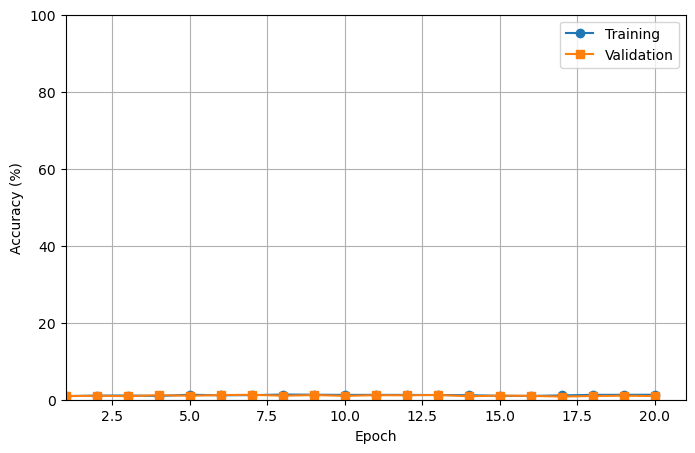

In [ ]:
facemodel,eyesmodel,fusionmodel=fusion_train(X_train,y_train,nb_epoch=150,labels=labels,batch_size=32,patience=20,val_split=True)


Epoch : 1/150
 Perte :680.8837
 Accuracy : 53.88%

 Val accuracy : 59.76%
 Série sans amélioration : 0

Epoch : 2/150
 Perte :648.3521
 Accuracy : 54.88%

 Val accuracy : 59.76%
 Série sans amélioration : 1

Epoch : 3/150
 Perte :656.3948
 Accuracy : 55.57%

 Val accuracy : 60.09%
 Série sans amélioration : 0

Epoch : 4/150
 Perte :648.6024
 Accuracy : 55.05%

 Val accuracy : 60.48%
 Série sans amélioration : 0

Epoch : 5/150
 Perte :643.8824
 Accuracy : 55.06%

 Val accuracy : 60.23%
 Série sans amélioration : 1

Epoch : 6/150
 Perte :630.5124
 Accuracy : 55.81%

 Val accuracy : 60.16%
 Série sans amélioration : 2

Epoch : 7/150
 Perte :627.7309
 Accuracy : 55.84%

 Val accuracy : 60.19%
 Série sans amélioration : 3

Epoch : 8/150
 Perte :625.4303
 Accuracy : 55.07%

 Val accuracy : 60.23%
 Série sans amélioration : 4

Epoch : 9/150
 Perte :628.4694
 Accuracy : 55.80%

 Val accuracy : 60.66%
 Série sans amélioration : 0

Epoch : 10/150
 Perte :625.3118
 Accuracy : 55.33%

 Val accura

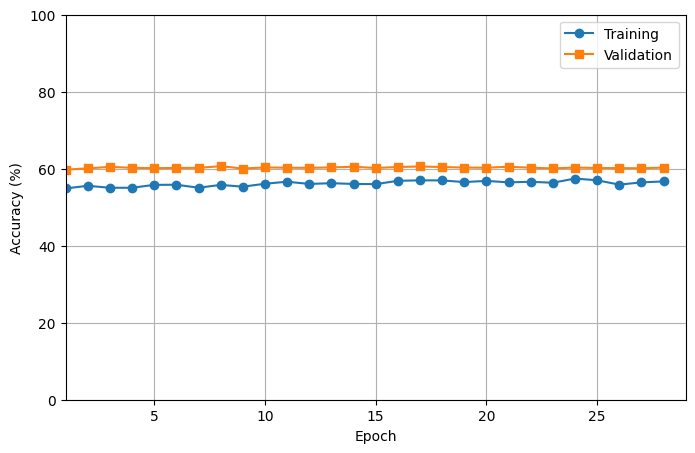

In [14]:
li="FusionModels/V2.2/"
models=[li+"facemodel3.pth",li+"eyesmodel3.pth",li+"fusionmodel3.pth"]
facemodel,eyesmodel,fusionmodel=fusion_train(X_train=X_train,y_train=y_train,nb_epoch=150,labels=labels,batch_size=32,patience=20,val_split=True,models=models)
torch.save(facemodel.state_dict(), "facemodel4.pth")
torch.save(eyesmodel.state_dict(), "eyesmodel4.pth")
torch.save(fusionmodel.state_dict(), "fusionmodel4.pth")
torch.save(facemodel.state_dict(), "facemodel4.pt")
torch.save(eyesmodel.state_dict(), "eyesmodel4.pt")
torch.save(fusionmodel.state_dict(), "fusionmodel4.pt")

Total accuracy : 49.96%


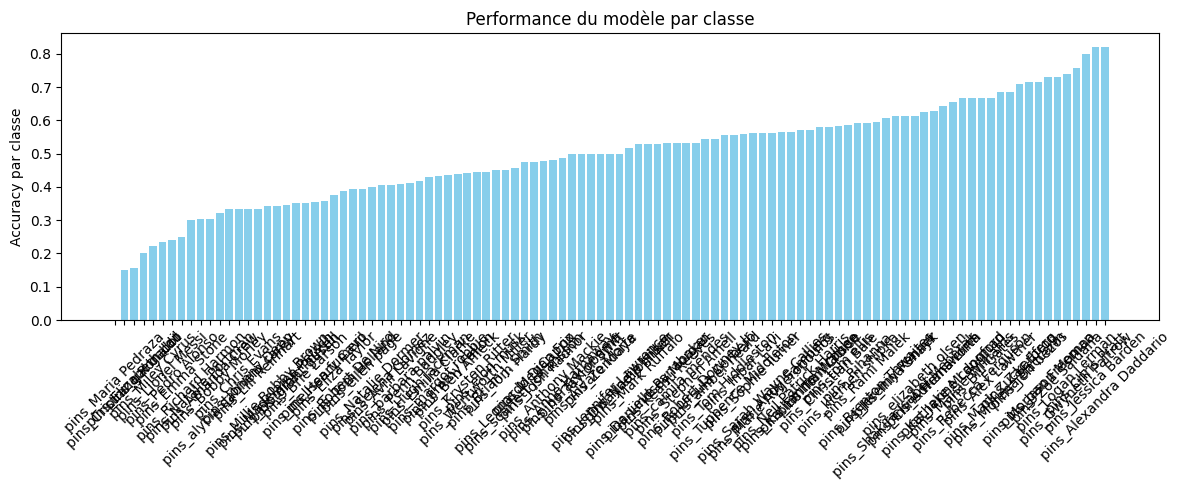

In [15]:
test_dataset=FaceEyesDataset(X_test,y_test,labels,transform_face=transform_face,transform_eyes=transform_eyes)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)
labelC,labelF,labelT=fusionEvaluate((facemodel,eyesmodel,fusionmodel),test_loader,labels,True)

In [50]:
torch.save(facemodel.state_dict(), "facemodel2.pth")
torch.save(eyesmodel.state_dict(), "eyesmodel2.pth")
torch.save(fusionmodel.state_dict(), "fusionmode2.pth")